In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
# Notebook in /ProjectRoot/notebooks
Proj_Root = os.path.join(os.pardir)

# Configuration

In [5]:
from src.data import config # local
from imutils import paths
import random

In [6]:
# Get the list of image paths
image_paths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(image_paths)
image_paths[:5]

['../data/raw/Parasitized/C132P93ThinF_IMG_20151004_153030_cell_31.png',
 '../data/raw/Uninfected/C132P93ThinF_IMG_20151004_152353_cell_51.png',
 '../data/raw/Uninfected/C232ThinF_IMG_20151112_154345_cell_258.png',
 '../data/raw/Uninfected/C99P60ThinF_IMG_20150918_141129_cell_15.png',
 '../data/raw/Parasitized/C45P6ThinF_IMG_20151130_155011_cell_174 (1).png']

### Raw Images

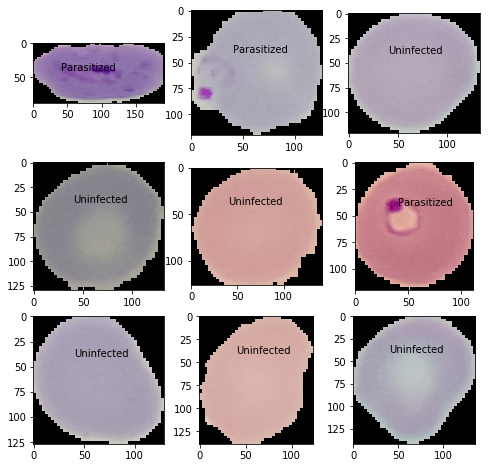

In [8]:
import matplotlib.image as mpimg


def plot_images():
    fig = plt.figure(figsize=(8,8))
    cols = 3
    rows = 3
    for i in range(1,cols*rows+1):
        sample_image = random.choice(image_paths)
        img = mpimg.imread(sample_image)
        sample_label = sample_image.split('/')[-2]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.text(40, 40, sample_label)
plot_images()
plt.savefig('../reports/figures/SamplesRawData.png')
plt.show()

> As we can see here cells with red spots are `Infected`. A clinician is supposed to detect and count this red blood cells to identify Maleria cases.

In [10]:
# create splitted data directories 
from src.data import make_data

make_data.split_data()

[INFO] building 'training' split
[INFO] building 'validation' split
[INFO] building 'testing' split
Data split is completed


In [7]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

print('TotalTrain Size: ', totalTrain)
print('TotalVal Size: ', totalVal)
print('TotalTest Size: ', totalTest)


TotalTrain Size:  22235
TotalVal Size:  2470
TotalTest Size:  6177


### Get Image Dimension Summary Stats

In [8]:
# Get file paths
train_files = list(paths.list_images(config.TRAIN_PATH))
val_files = list(paths.list_images(config.VAL_PATH))
test_files = list(paths.list_images(config.TEST_PATH))

In [9]:
# Get labels

train_labels = []

for i in range(totalTrain):
    label = train_files[i].split('/')[4]
    train_labels.append(label)
print('Train Labels: ',len(train_labels))

Train Labels:  22235


In [10]:
val_labels = []
for i in range(totalVal):
    label = val_files[i].split('/')[4]
    val_labels.append(label)
print('Validation Labels: ',len(val_labels))

Validation Labels:  2470


In [11]:
test_labels = []
for i in range(totalTest):
    label = test_files[i].split('/')[4]
    test_labels.append(label)
print('Test Labels: ',len(test_labels))

Test Labels:  6177


In [10]:
import cv2
from concurrent import futures
import threading


def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, totalTrain) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_15: working on img num: 5000
ThreadPoolExecutor-0_2: working on img num: 10000
ThreadPoolExecutor-0_8: working on img num: 15000
ThreadPoolExecutor-0_7: working on img num: 20000
ThreadPoolExecutor-0_15: working on img num: 22234
Min Dimensions: [40 49  3]
Avg Dimensions: [133.16770857 132.61506634   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 364   3]


### Load and Resize Images

In [11]:
IMG_SIZE = (64, 64) # to save time with CPU


def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_SIZE,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img


ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files))
                  for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files))
                for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files))
                 for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel,
                      [record[0] for record in val_data_inp],
                      [record[1] for record in val_data_inp],
                      [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel,
                       [record[0] for record in test_data_inp],
                       [record[1] for record in test_data_inp],
                       [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_4: working on img num: 5000
ThreadPoolExecutor-1_19: working on img num: 10000
ThreadPoolExecutor-1_6: working on img num: 15000
ThreadPoolExecutor-1_11: working on img num: 20000
ThreadPoolExecutor-1_0: working on img num: 22234

Loading Validation Images:
ThreadPoolExecutor-1_16: working on img num: 0
ThreadPoolExecutor-1_10: working on img num: 2469

Loading Test Images:
ThreadPoolExecutor-1_17: working on img num: 0
ThreadPoolExecutor-1_14: working on img num: 5000
ThreadPoolExecutor-1_15: working on img num: 6176


((22235, 64, 64, 3), (2470, 64, 64, 3), (6177, 64, 64, 3))

In [12]:
columns = ['SampleSize', 'Height', 'Width', 'ColorChannel']
index = ['TrainData', 'Validation', 'Test']
shapes = pd.DataFrame(np.stack((train_data.shape, val_data.shape, test_data.shape)),
            columns=columns, index=index)
# save for reports
shapes.to_html("../reports/figures/image_tensor_data.html")
shapes

,SampleSize,Height,Width,ColorChannel
TrainData,22235,64,64,3
Validation,2470,64,64,3
Test,6177,64,64,3


### View Resized Images

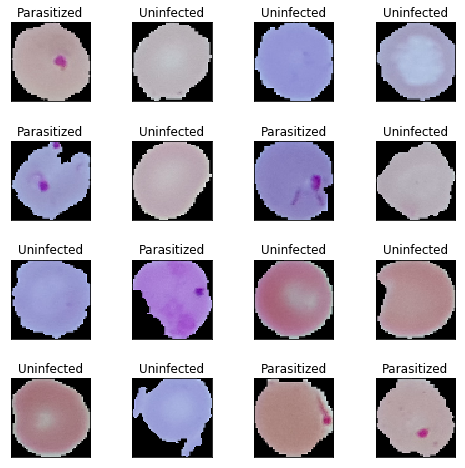

In [19]:
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])
plt.savefig('../reports/figures/Samples64643Data.png')
plt.show()

### PreProcessing: Scale and Encode Datasets 

In [15]:
train_data_scaled = train_data / 255.
val_data_scaled = val_data / 255.

train_data_reshaped = train_data_scaled.reshape(-1, 64*64*3)
val_data_reshaped = val_data_scaled.reshape((-1,64*64*3))
# encode text labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
val_labels_encoded = le.transform(val_labels)

print(train_labels[:8], train_labels_encoded[:8])

['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized'] [0 0 0 0 0 0 0 0]


# Modelling 

## Model1: KNN

The k-Nearest Neighbor classifier is by far the most simple machine learning and image classi- fication algorithm. In fact, it’s so simple that it doesn’t actually “learn” anything. Instead, this algorithm directly relies on the distance between feature vectors. Each data point in the k closest data points casts a vote, and the category with the highest number of votes wins. Or the category with the largest number of votes in the k closest training points wins and is used as the label for the input data point.

This is how KNN works in the background:
- Calculate the distance between the new point and every other point
- Sort the distances
- Pick K minimum distances from the list of sorted distances 
- Use majrity voting to get the color/label of the point

In [23]:
# fit KNN
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors


k = 5
model_knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
model_knn.fit(train_data_reshaped, train_labels_encoded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
# results
acc = model_knn.score(val_data_reshaped, val_labels_encoded)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc*100))

In [25]:
from sklearn.metrics import classification_report
print(classification_report(val_labels_encoded,
                            model_knn.predict(val_data_reshaped)))

              precision    recall  f1-score   support

           0       0.75      0.43      0.55      1417
           1       0.51      0.81      0.63      1053

   micro avg       0.59      0.59      0.59      2470
   macro avg       0.63      0.62      0.59      2470
weighted avg       0.65      0.59      0.58      2470



In [26]:
# Bare count of classes
val_labels_encoded.sum() / val_labels_encoded.shape[0]

0.4263157894736842


- As you can see from `support`, we do have a good distriution of class samples which prevents unbalanced dataset problems. 
- We have got 59 % accuracy score with KNN which is not too bad even with this not learning method, given that the probability of randomly guessing the correct class is 50 %. 
- KNN model correctly classified parasitized blood cells 51 % of the time. These are the cells with red dots.
- Looks like KNN did a better job on classifiying `uninfected` class based on the Precision score. Apparently, some `uninfected` cells classified as  `infected` (False Positive) as we can see from  Precision score of `infected` class.
- The harmonic mean is generally used instead of the standard arithmetic mean when dealing with rates. So we use harmonic mean to get F1 score which is simply just the average of precision and recall.
- Now that we have obtained a baseline for image classification using the k-NN algorithm, we can move on the parameterized learning, the foundation on which all deep learning and neural networks are built on. Using parameterized learning, we can actually learn from our input data and discover underlying patterns

## Model 2: Simple Neural Network

In [27]:
train_labels_encoded.shape

(22235,)

In [37]:
from keras.models import Sequential
from keras import layers



BATCH_SIZE = 128
NUM_CLASSES = 2
EPOCHS = 10


model_snn = Sequential()
# flatten the tensor for Dense layers since each sample has 64x64x3 elements enter this
model_snn.add(layers.Dense(512, activation='relu', input_shape=(64*64*3,)))
model_snn.add(layers.Dense(64, activation='relu'))
model_snn.add(layers.Dense(1, activation='sigmoid'))
model_snn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               6291968   
_________________________________________________________________
dense_26 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 6,324,865
Trainable params: 6,324,865
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Dense layers needs to 2D data so use reshaped forms
print('[INFO] compiling model...')
model_snn.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

H = model_snn.fit(train_data_reshaped,
                  train_labels_encoded,
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE,
                  validation_data=(val_data_reshaped, val_labels_encoded))

[INFO] compiling model...
Train on 22235 samples, validate on 2470 samples
Epoch 1/10
22235/22235 [==============================] - 12s 525us/step - loss: 7.1552 - acc: 0.5533 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 2/10
22235/22235 [==============================] - 11s 498us/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 3/10
22235/22235 [==============================] - 11s 498us/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 4/10
22235/22235 [==============================] - 11s 500us/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 5/10
22235/22235 [==============================] - 11s 493us/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 6/10
22235/22235 [==============================] - 11s 494us/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 7/10
22235/22235 [==============================] - 11s 495us/step - loss: 7.1874 - a

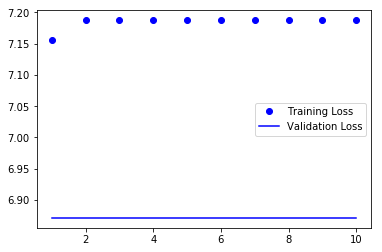

In [42]:
history_dict = H.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.legend()
plt.savefig('../reports/figures/SimpleNNLoss.png')
plt.show()

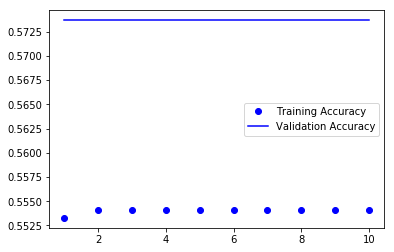

In [43]:
training_acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, training_acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.legend()
plt.savefig('../reports/figures/SimpleNNAccuracy.png')
plt.show()

##  Model 3: CNN 

In [49]:
import keras
# define the total number of epochs to train for along with the
# initial learning rate and batch size

BATCH_SIZE = 128
NUM_CLASSES = 2
EPOCHS = 5
INPUT_SHAPE = (64, 64, 3)



inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = keras.layers.Flatten()(pool3)

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
drop1 = keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = keras.layers.Dense(512, activation='relu')(drop1)
drop2 = keras.layers.Dropout(rate=0.3)(hidden2)

out = keras.layers.Dense(1, activation='sigmoid')(drop2)

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [54]:
# define our set of callbacks and fit the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr]

history = model.fit(x=train_data_scaled, y=train_labels_encoded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_data_scaled, val_labels_encoded), 
                    callbacks=callbacks,
                    verbose=1)

Train on 22235 samples, validate on 2470 samples
Epoch 1/5
22235/22235 [==============================] - 97s 4ms/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 2/5
22235/22235 [==============================] - 102s 5ms/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 3/5
22235/22235 [==============================] - 102s 5ms/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 4/5
22235/22235 [==============================] - 96s 4ms/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737
Epoch 5/5
22235/22235 [==============================] - 93s 4ms/step - loss: 7.1874 - acc: 0.5541 - val_loss: 6.8714 - val_acc: 0.5737


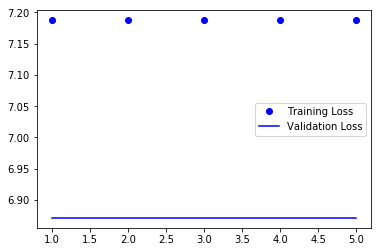

In [55]:
history_dictCNN = history.history
loss_values = history_dictCNN['loss']
val_loss_values = history_dictCNN['val_loss']
epochs = range(1, len(history_dictCNN['acc']) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.legend()
plt.savefig('../reports/figures/CNNLoss.png')
plt.show()

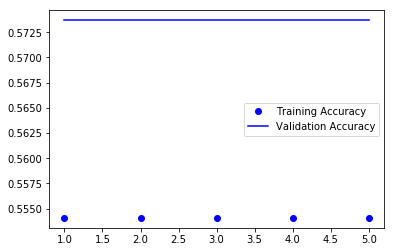

In [56]:
training_acc_values = history_dictCNN['acc']
val_acc_values = history_dictCNN['val_acc']
epochs = range(1, len(history_dictCNN['acc']) + 1)

plt.plot(epochs, training_acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.legend()
plt.savefig('../reports/figures/CNNAccuracy.png')
plt.show()

> The accuracy is not good at all. The reason for this might be the size of the images is not good enough or something else..

## Model 3: ResNet Model

In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from src.models.resnet import ResNet
from keras.callbacks import LearningRateScheduler


BATCH_SIZE = 128
NUM_EPOCHS = 5
INIT_LR = 1e-1
NUM_CLASSES = 2


def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
 
    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
 
    # return the new learning rate
    return alpha

In [26]:
# Initialize the training data augmentation object
# This process is recommended for every deep learning dataset 
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [27]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    config.TRAIN_PATH,
    class_mode="categorical",
    target_size=(64, 64),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

Found 22235 images belonging to 2 classes.


In [28]:
# initialize the validation generator
valGen = valAug.flow_from_directory(
    config.VAL_PATH,
    class_mode="categorical",
    target_size=(64, 64),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)


Found 2470 images belonging to 2 classes.


In [29]:
# initialize the testing generator
testGen = valAug.flow_from_directory(
    config.TEST_PATH,
    class_mode="categorical",
    target_size=(64, 64),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 6177 images belonging to 2 classes.


In [30]:
model_res = ResNet.build(64, 64, 3, 2, (3, 4,6),(64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=INIT_LR, momentum=0.9)
model_res.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [31]:
# callbacks 
callbacks = [LearningRateScheduler(poly_decay)]

history_res = model_res.fit_generator(
        trainGen,
        steps_per_epoch=totalTrain//BATCH_SIZE,
        validation_data=valGen,
        validation_steps=totalVal//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=callbacks)

Epoch 1/5
173/173 [==============================] - 1420s 8s/step - loss: 1.0713 - acc: 0.8311 - val_loss: 0.6936 - val_acc: 0.9552
Epoch 2/5
173/173 [==============================] - 1362s 8s/step - loss: 0.6732 - acc: 0.9525 - val_loss: 0.6540 - val_acc: 0.9547
Epoch 3/5
173/173 [==============================] - 1370s 8s/step - loss: 0.6271 - acc: 0.9558 - val_loss: 0.6110 - val_acc: 0.9569
Epoch 4/5
173/173 [==============================] - 6565s 38s/step - loss: 0.6002 - acc: 0.9586 - val_loss: 0.5852 - val_acc: 0.9599
Epoch 5/5
173/173 [==============================] - 1347s 8s/step - loss: 0.5823 - acc: 0.9594 - val_loss: 0.5767 - val_acc: 0.9599


In [32]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model_res.predict_generator(testGen,
    steps=(totalTest // BATCH_SIZE) + 1)
 
# # for each image in the testing set we need to find the index of the
# # label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
 


[INFO] evaluating network...


In [33]:
from sklearn.metrics import classification_report

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
                            target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

 Parasitized       0.98      0.95      0.96      3366
  Uninfected       0.94      0.97      0.96      2811

   micro avg       0.96      0.96      0.96      6177
   macro avg       0.96      0.96      0.96      6177
weighted avg       0.96      0.96      0.96      6177



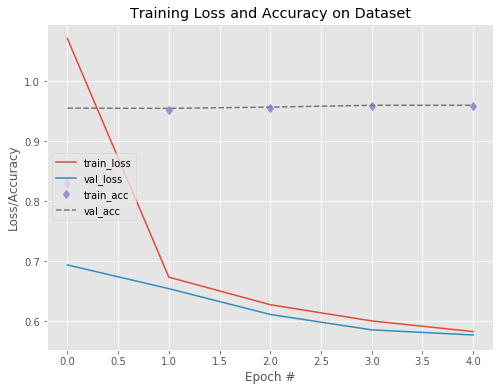

In [36]:
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_res.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_res.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history_res.history["acc"],'d', label="train_acc")
plt.plot(np.arange(0, N), history_res.history["val_acc"],'--', label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center left")
plt.savefig('../reports/figures/ResNet.png')